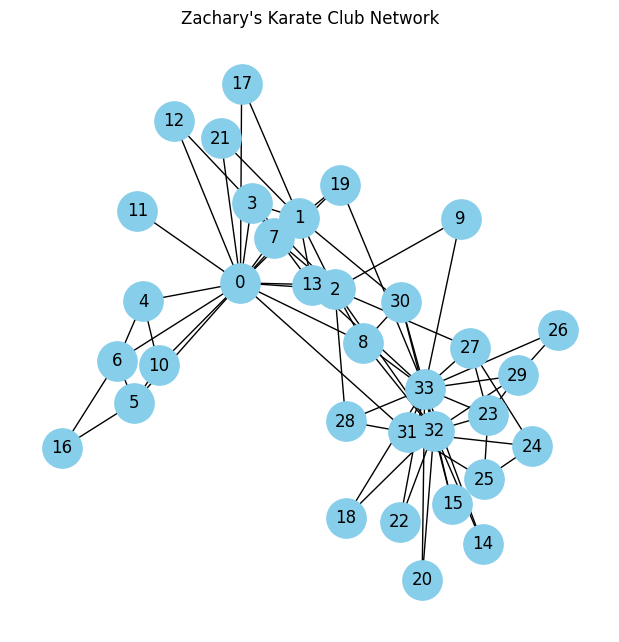

Detected Communities (Level 1):
Community 1: [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Community 2: [2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


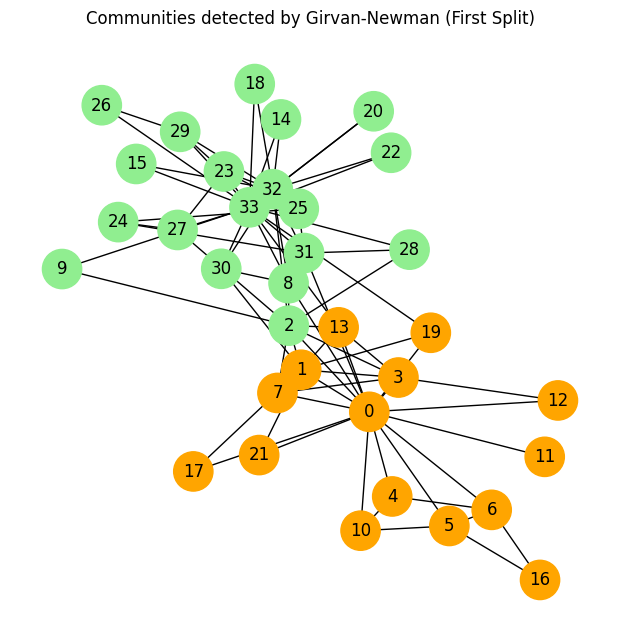


Best partition by modularity:
Community 1: [0, 1, 3, 7, 11, 12, 13, 17, 19, 21]
Community 2: [2, 24, 25, 27, 28, 31]
Community 3: [4, 5, 6, 10, 16]
Community 4: [8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33]
Community 5: [9]
Modularity: 0.3850

EVALUATION METRICS
Accuracy:  0.9412
Precision: 0.8947
Recall:    1.0000
F1-Score:  0.9444

Confusion Matrix:
[[15  2]
 [ 0 17]]
True Negatives:  15
False Positives: 2
False Negatives: 0
True Positives:  17

ROC AUC Score: 0.9965


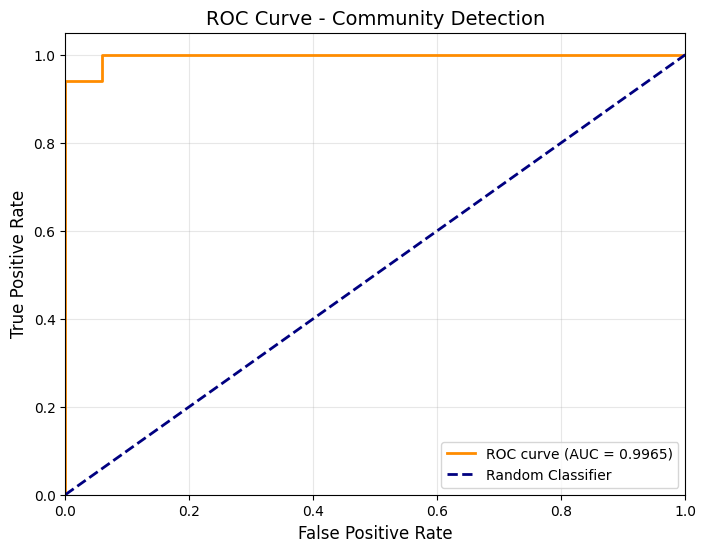

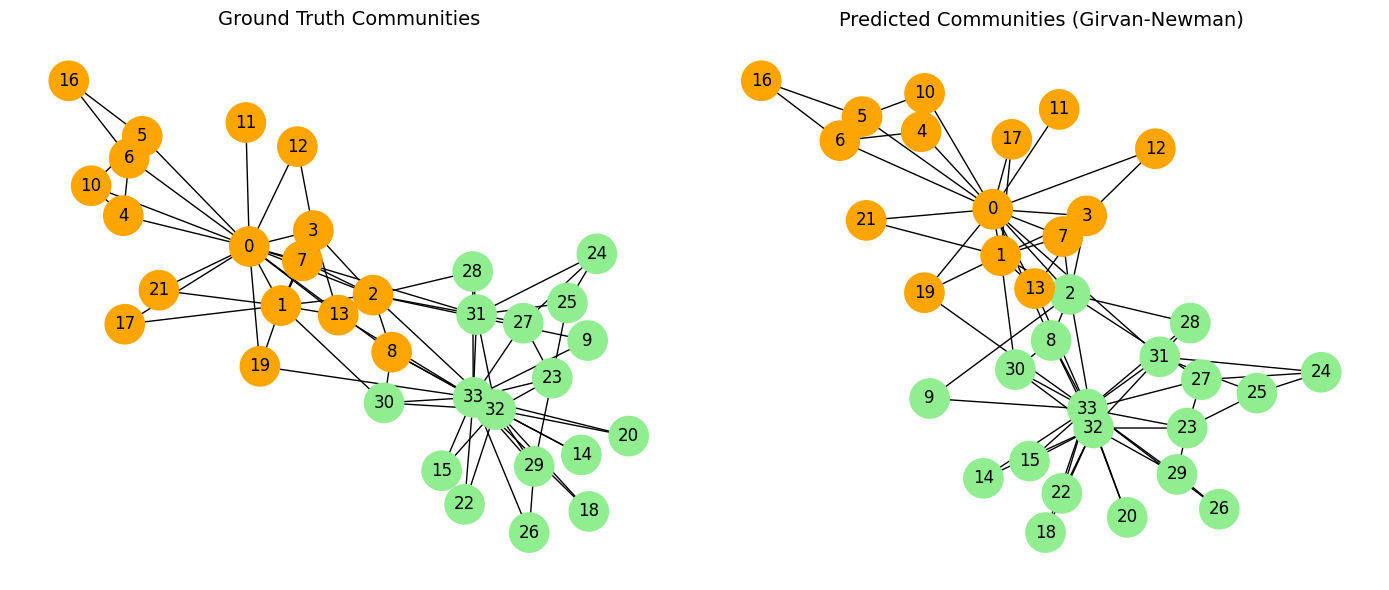


Analysis Complete!


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community.quality import modularity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
import numpy as np

# Load the Zachary's Karate Club graph
G = nx.karate_club_graph()

# Draw the initial network
plt.figure(figsize=(6, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=800)
plt.title("Zachary's Karate Club Network")
plt.show()

# Apply the Girvan–Newman algorithm
comp = girvan_newman(G)

# Get the first few community divisions
first_level = next(comp)  # first split
second_level = next(comp) # second split

# Convert tuple of sets to list of lists
communities = [list(c) for c in first_level]

print("Detected Communities (Level 1):")
for i, com in enumerate(communities):
    print(f"Community {i+1}: {com}")

# Visualize the detected communities
color_map = []
for node in G:
    if node in communities[0]:
        color_map.append('orange')
    else:
        color_map.append('lightgreen')

plt.figure(figsize=(6,6))
nx.draw(G, node_color=color_map, with_labels=True, node_size=800)
plt.title("Communities detected by Girvan-Newman (First Split)")
plt.show()

best_partition = max(comp, key=lambda c: modularity(G, c))
print("\nBest partition by modularity:")
for i, com in enumerate(best_partition):
    print(f"Community {i+1}: {sorted(list(com))}")

print(f"Modularity: {modularity(G, best_partition):.4f}")

# ============================================================================
# EVALUATION METRICS
# ============================================================================

# Get ground truth labels from the karate club graph
# The 'club' attribute contains the actual faction each member joined
ground_truth = []
for node in G.nodes():
    # 'Mr. Hi' = 0, 'Officer' = 1
    ground_truth.append(0 if G.nodes[node]['club'] == 'Mr. Hi' else 1)

# Create predicted labels from first split
predicted = []
for node in G.nodes():
    if node in communities[0]:
        predicted.append(0)
    else:
        predicted.append(1)

# We might need to flip labels if they're inverted
# Check which alignment gives better accuracy
accuracy1 = accuracy_score(ground_truth, predicted)
predicted_flipped = [1 - p for p in predicted]
accuracy2 = accuracy_score(ground_truth, predicted_flipped)

if accuracy2 > accuracy1:
    predicted = predicted_flipped
    print("\n(Labels were flipped for better alignment with ground truth)")

# Calculate metrics
accuracy = accuracy_score(ground_truth, predicted)
precision = precision_score(ground_truth, predicted, zero_division=0)
recall = recall_score(ground_truth, predicted, zero_division=0)
f1 = f1_score(ground_truth, predicted, zero_division=0)

print("\n" + "="*60)
print("EVALUATION METRICS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(ground_truth, predicted)
print("\nConfusion Matrix:")
print(cm)
print(f"True Negatives:  {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives:  {cm[1,1]}")

# ============================================================================
# ROC CURVE and AUC
# ============================================================================

# For ROC curve, we need probability scores
# We'll use a proxy: the degree centrality or distance-based probability
# Here we'll use a simple approach: distance from community centroid

def get_probability_scores(G, communities):
    """
    Generate probability scores based on node connectivity within communities.
    Nodes strongly connected to community 1 get higher scores.
    """
    scores = np.zeros(len(G.nodes()))
    
    comm0_nodes = set(communities[0])
    comm1_nodes = set(communities[1])
    
    for node in G.nodes():
        # Count edges to each community
        edges_to_comm0 = sum(1 for neighbor in G.neighbors(node) if neighbor in comm0_nodes)
        edges_to_comm1 = sum(1 for neighbor in G.neighbors(node) if neighbor in comm1_nodes)
        
        total_edges = edges_to_comm0 + edges_to_comm1
        if total_edges > 0:
            # Probability of belonging to community 1
            scores[node] = edges_to_comm1 / total_edges
        else:
            scores[node] = 0.5  # neutral if no edges
    
    return scores

# Get probability scores
prob_scores = get_probability_scores(G, communities)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(ground_truth, prob_scores)
roc_auc = auc(fpr, tpr)

print("\n" + "="*60)
print(f"ROC AUC Score: {roc_auc:.4f}")
print("="*60)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Community Detection', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# ============================================================================
# Visualize Ground Truth vs Predicted
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Ground truth visualization
color_map_true = ['orange' if gt == 0 else 'lightgreen' for gt in ground_truth]
nx.draw(G, ax=axes[0], node_color=color_map_true, with_labels=True, node_size=800)
axes[0].set_title("Ground Truth Communities", fontsize=14)

# Predicted visualization
color_map_pred = ['orange' if p == 0 else 'lightgreen' for p in predicted]
nx.draw(G, ax=axes[1], node_color=color_map_pred, with_labels=True, node_size=800)
axes[1].set_title("Predicted Communities (Girvan-Newman)", fontsize=14)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Analysis Complete!")
print("="*60)

Top bridging edges by betweenness centrality:
(31, 13): 0.3755
(32, 31): 0.2644
(30, 8): 0.2139
(0, 1): 0.2112
(3, 13): 0.2089
(1, 13): 0.1723
(31, 8): 0.1438
(0, 3): 0.1414
(8, 2): 0.1378
(23, 32): 0.1304

Removed edges: [(31, 13), (32, 31), (30, 8), (0, 1), (3, 13)]


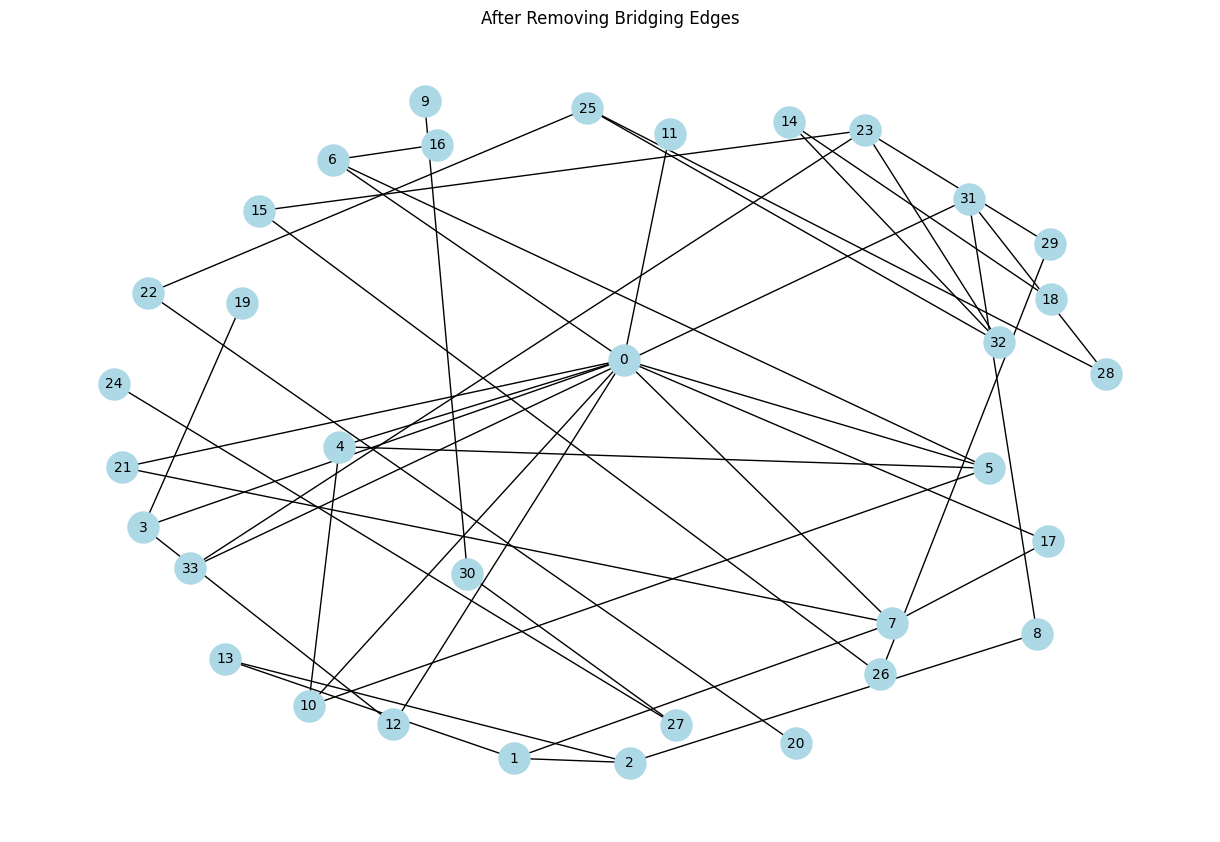


Number of components: 2
Component 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, 31, 32, 33]
Component 1: [9, 24, 27, 30]


In [1]:
import networkx as nx
import matplotlib.pyplot as plt

# Create your graph from the visualization
G = nx.Graph()

# Add edges based on your diagram
# Green community edges
edges_green = [(26,29), (26,15), (29,23), (15,23), (23,32), (23,33), (32,25), 
               (32,31), (33,31), (18,14), (14,32), (20,22), (22,25), (25,28), 
               (31,28), (24,27), (27,30), (9,30), (30,8), (8,31), (8,2)]

# Orange community edges
edges_orange = [(0,1), (0,3), (0,7), (0,12), (0,11), (0,4), (0,5), (0,6), 
                (0,10), (0,21), (0,17), (1,7), (1,13), (3,13), (3,12), (3,19),
                (7,21), (7,17), (4,5), (5,6), (5,10), (6,16), (10,4)]

# Bridging edges (between communities) - THESE ARE THE ONES TO REMOVE
edges_bridge = [(2,13), (2,8), (8,31), (13,31), (2,1), (13,3)]

G.add_edges_from(edges_green + edges_orange + edges_bridge)

# Step 1: Calculate edge betweenness centrality
edge_betweenness = nx.edge_betweenness_centrality(G)

# Step 2: Sort by betweenness (highest first)
sorted_edges = sorted(edge_betweenness.items(), key=lambda x: x[1], reverse=True)

print("Top bridging edges by betweenness centrality:")
for edge, betweenness in sorted_edges[:10]:
    print(f"{edge}: {betweenness:.4f}")

# Step 3: Remove the top X edges (start with 5-10)
edges_to_remove = [edge[0] for edge in sorted_edges[:5]]
G.remove_edges_from(edges_to_remove)

print(f"\nRemoved edges: {edges_to_remove}")

# Step 4: Visualize the result
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=2, iterations=50)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.title("After Removing Bridging Edges")
plt.show()

# Step 5: Check connected components
components = list(nx.connected_components(G))
print(f"\nNumber of components: {len(components)}")
for i, comp in enumerate(components):
    print(f"Component {i}: {sorted(comp)}")

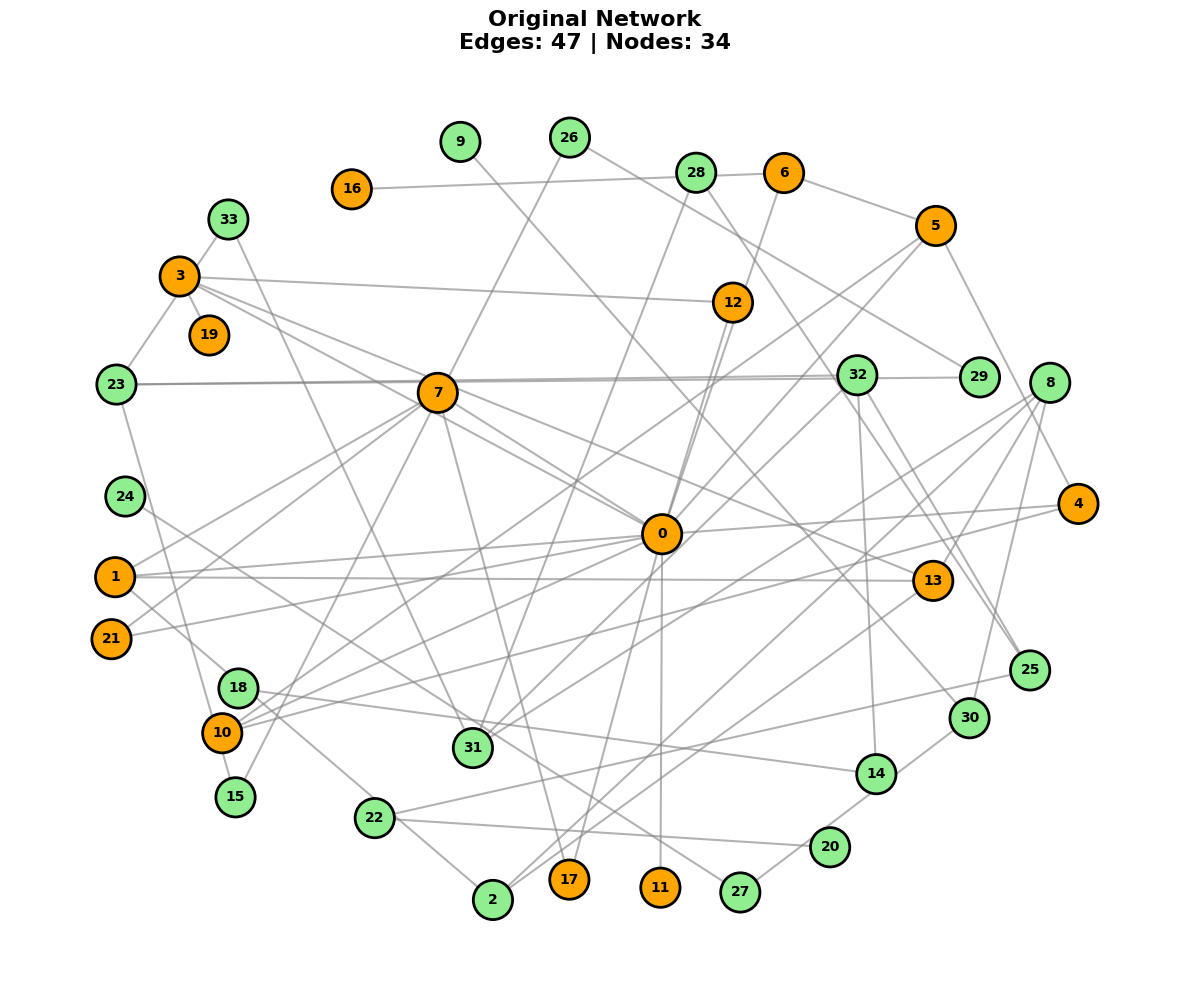

Removed 1 edges: [(2, 13)]
Remaining edges: 46



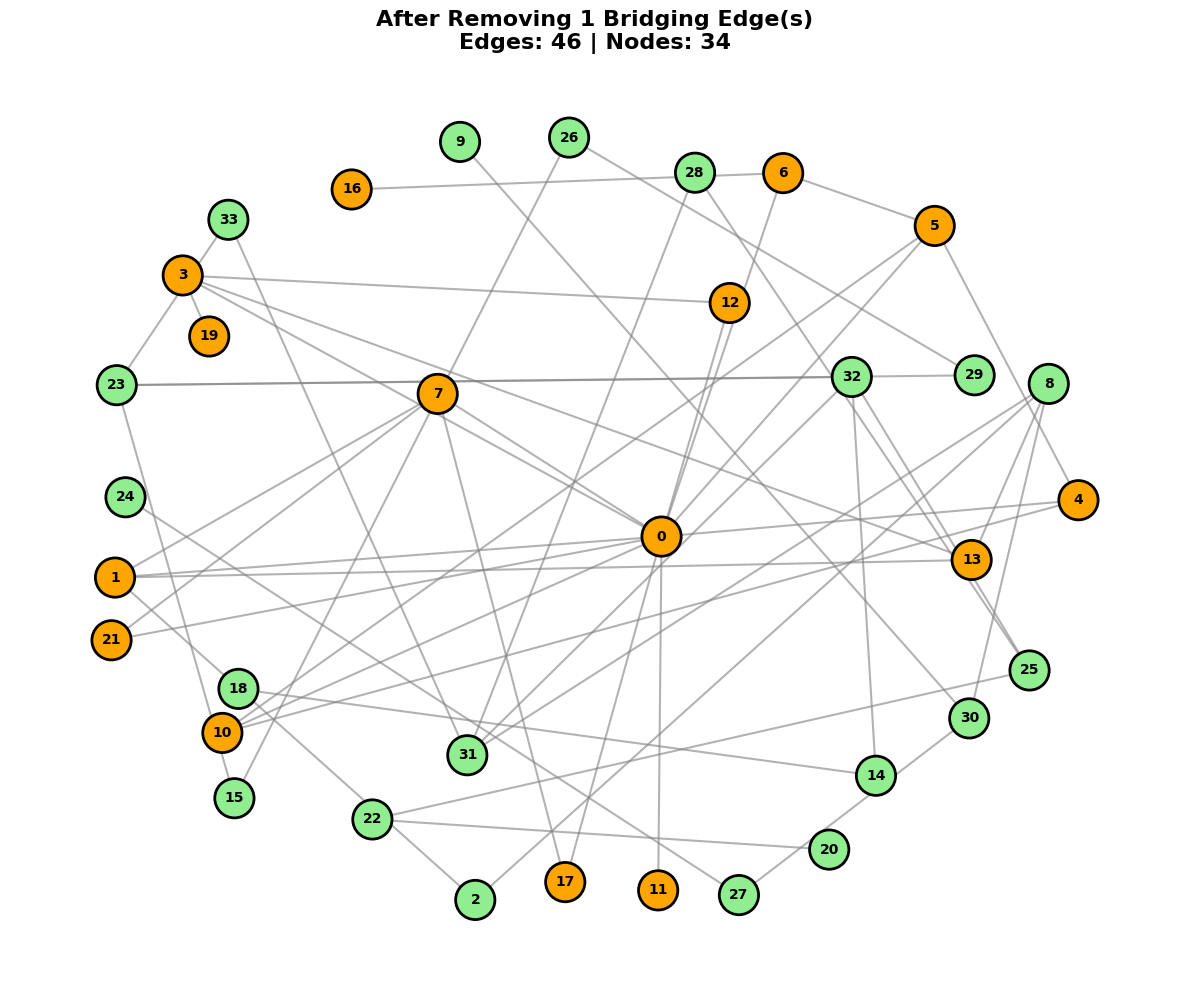

Removed 2 edges: [(2, 13), (2, 1)]
Remaining edges: 45



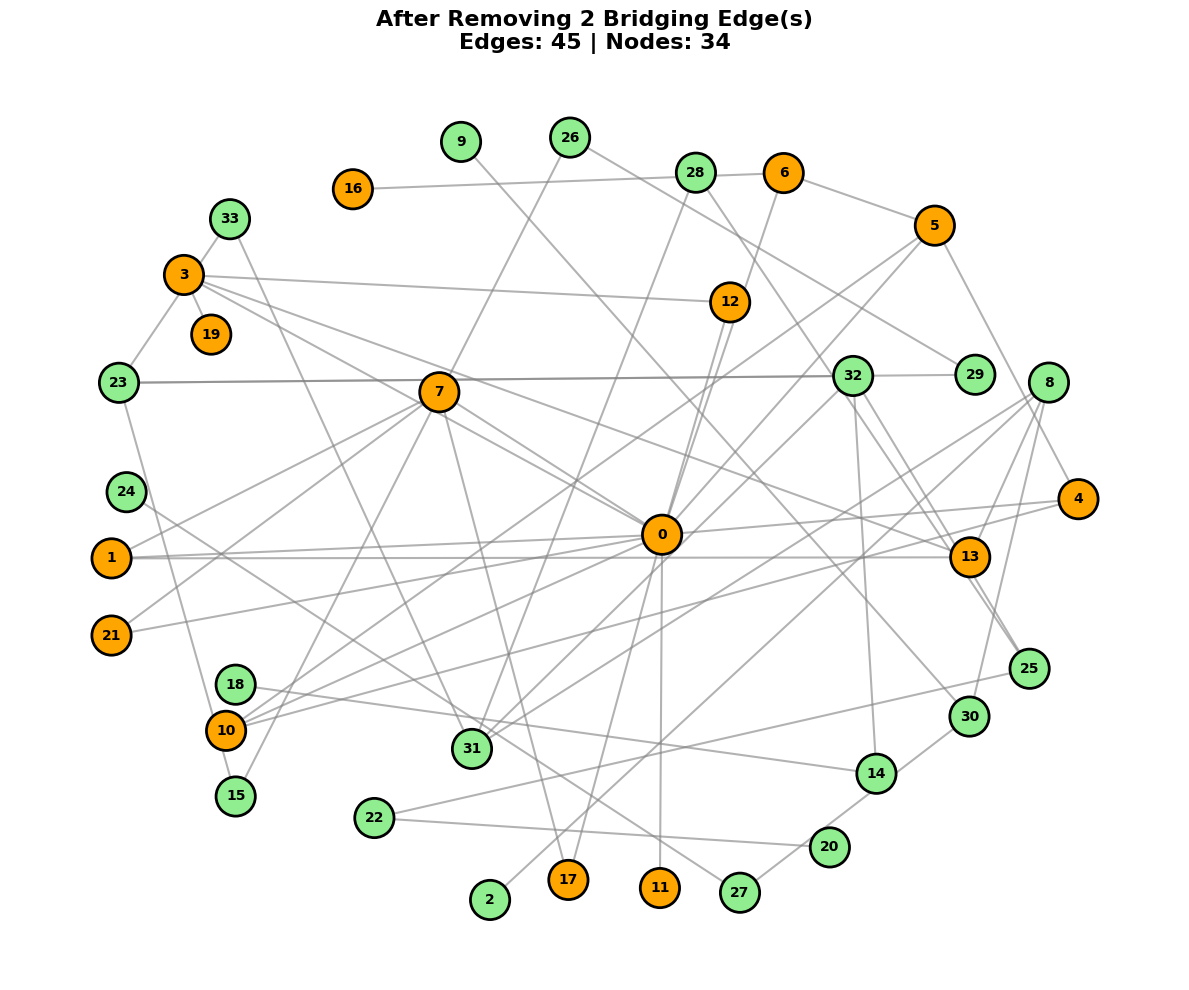

Removed 3 edges: [(2, 13), (2, 1), (13, 3)]
Remaining edges: 44



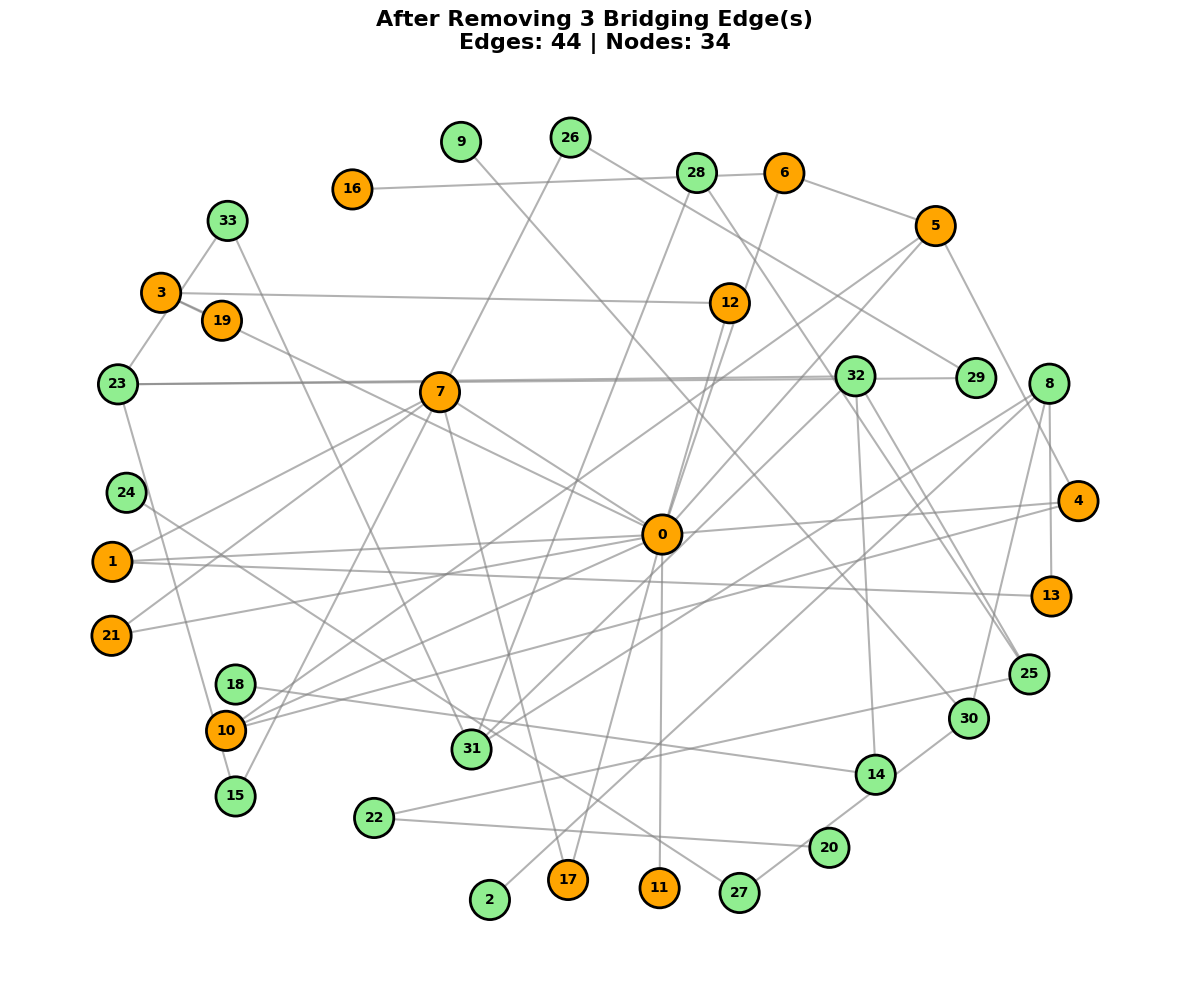

Removed 4 edges: [(2, 13), (2, 1), (13, 3), (13, 8)]
Remaining edges: 43



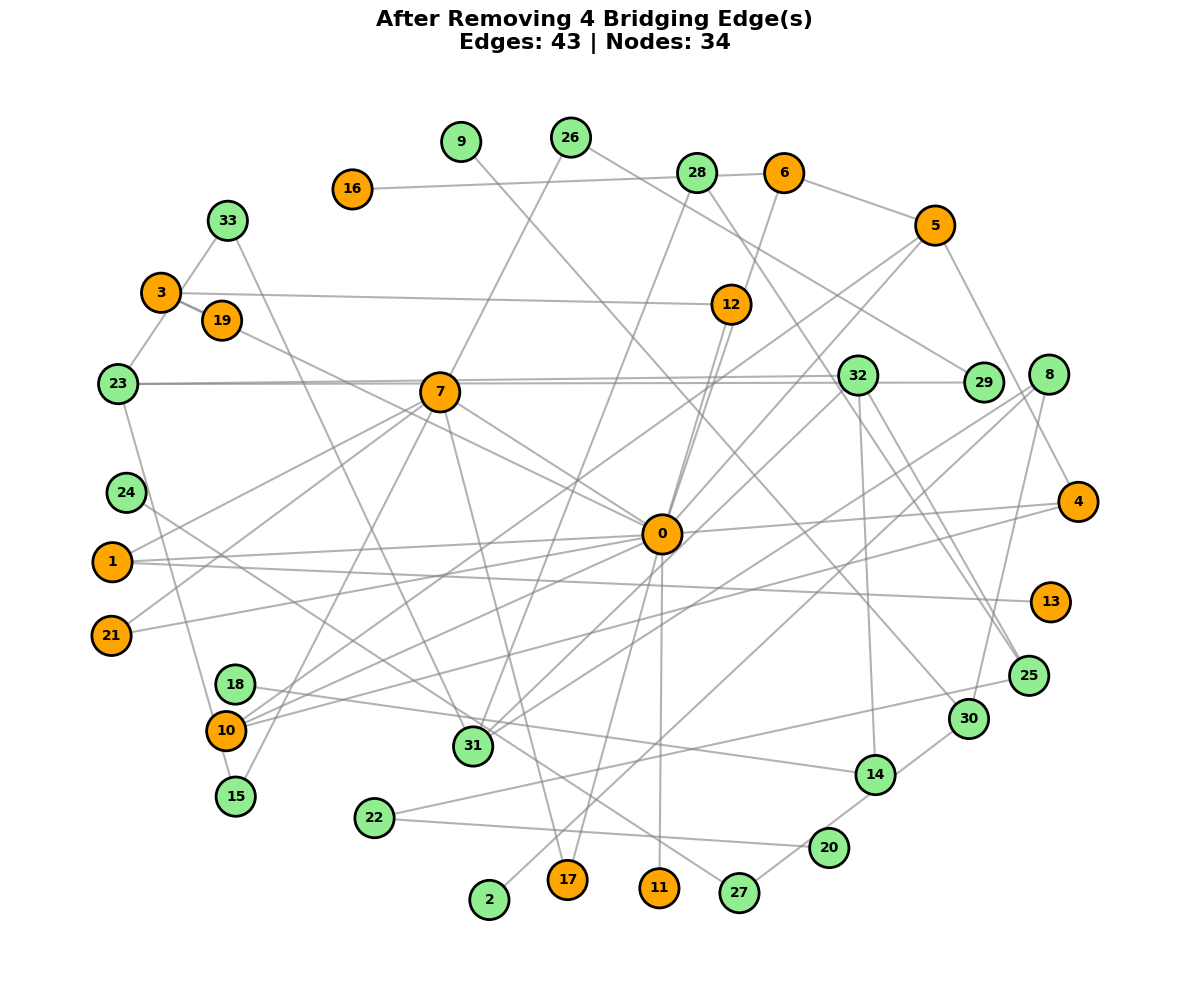

Removed 5 edges: [(2, 13), (2, 1), (13, 3), (13, 8), (2, 8)]
Remaining edges: 42



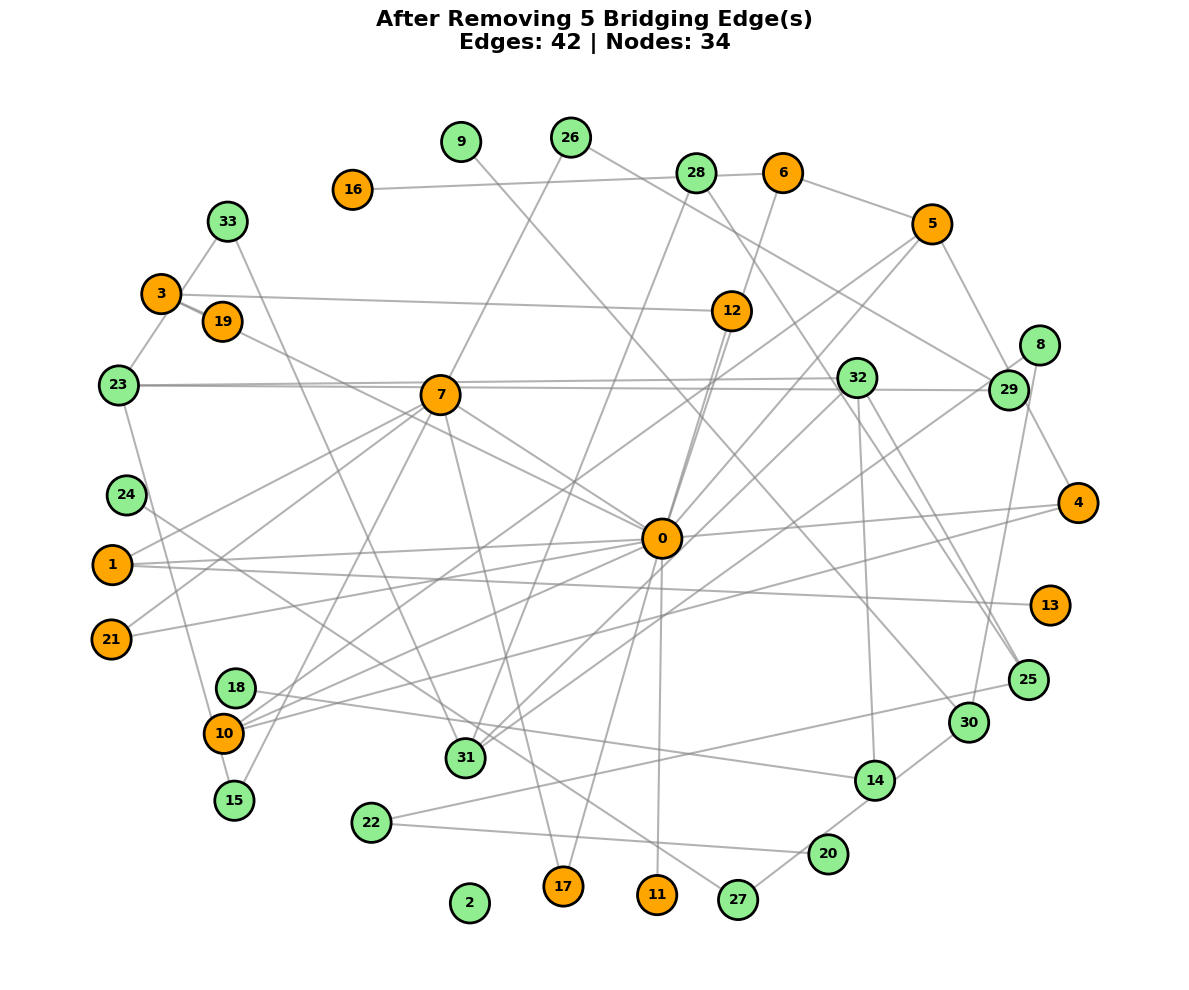

Removed 6 edges: [(2, 13), (2, 1), (13, 3), (13, 8), (2, 8), (8, 31)]
Remaining edges: 41



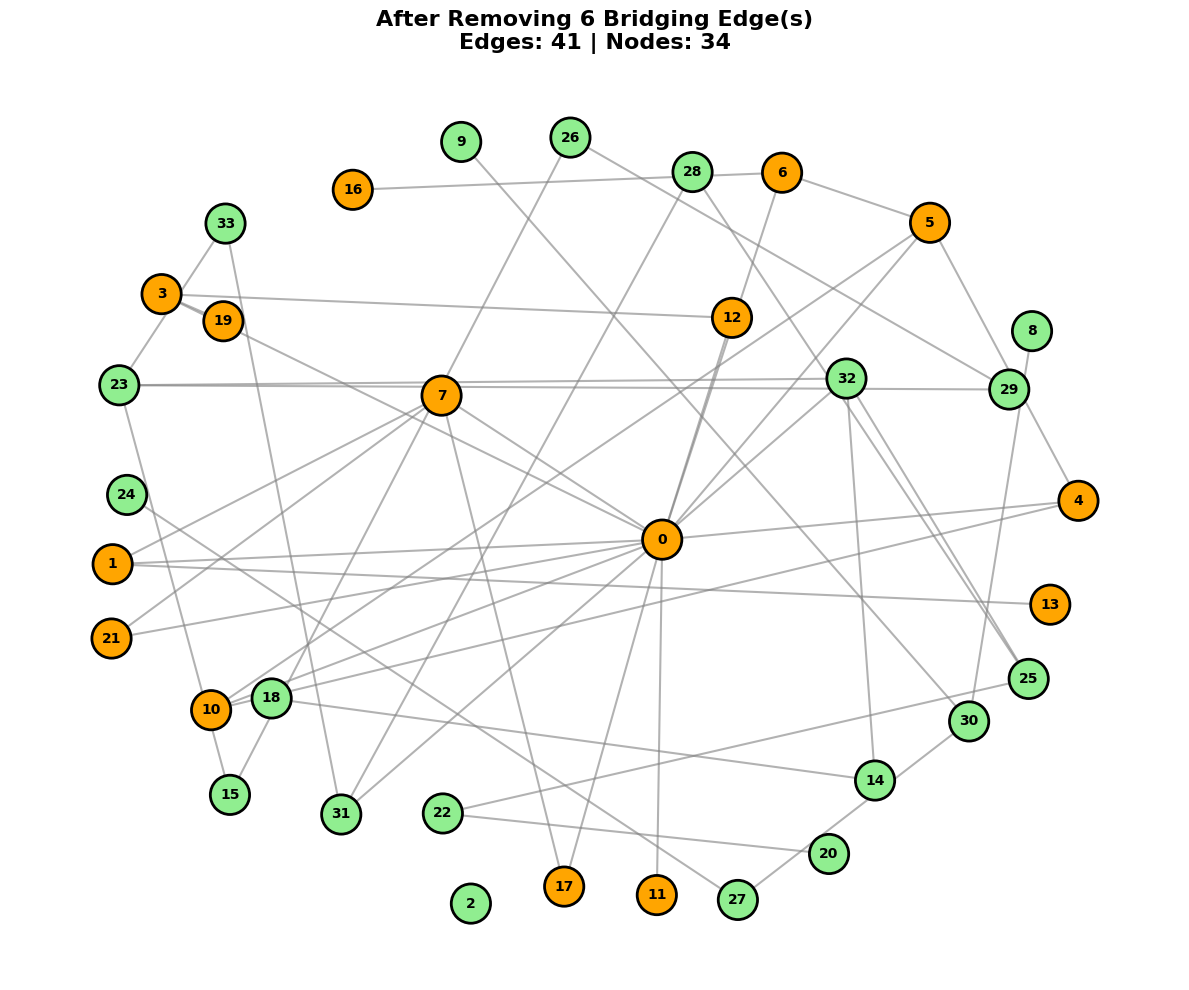


FINAL RESULT: After removing all 6 bridging edges
Number of separate components: 4
Component 1: [14, 15, 18, 20, 22, 23, 25, 26, 28, 29, 31, 32, 33]
Component 2: [8, 9, 24, 27, 30]
Component 3: [2]
Component 4: [0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]
Total edges remaining: 41


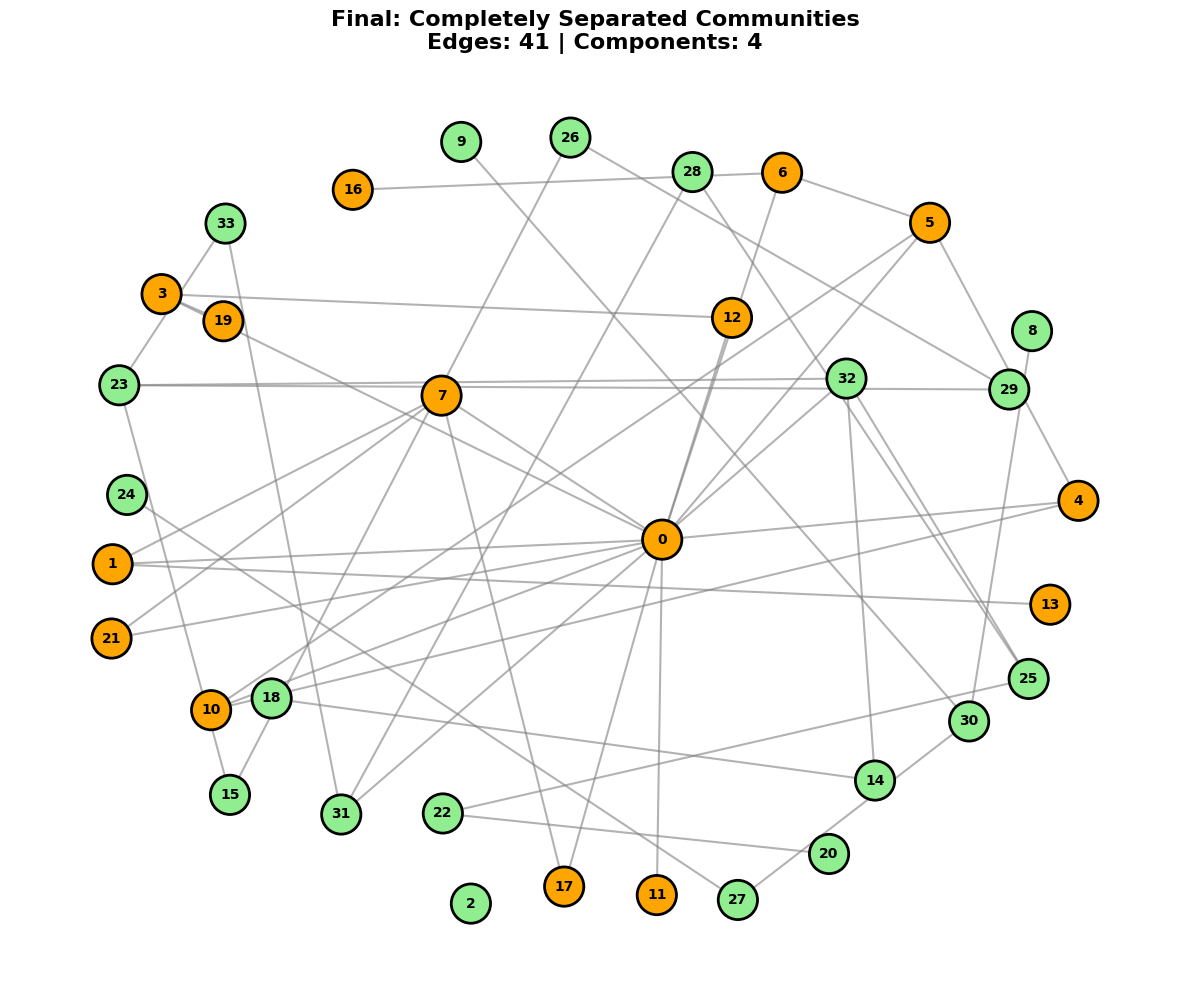

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Define communities
green_community = [26, 29, 15, 23, 32, 33, 25, 31, 28, 18, 14, 20, 22, 24, 27, 30, 9, 8, 2]
orange_community = [0, 1, 3, 7, 12, 11, 4, 5, 6, 10, 21, 17, 13, 19, 16]

# Define all edges
green_edges = [(26,29), (26,15), (29,23), (15,23), (23,32), (23,33), (32,25),
               (32,31), (33,31), (18,14), (14,32), (20,22), (22,25), (25,28),
               (31,28), (24,27), (27,30), (9,30), (30,8), (8,31), (8,2)]

orange_edges = [(0,1), (0,3), (0,7), (0,12), (0,11), (0,4), (0,5), (0,6),
                (0,10), (0,21), (0,17), (1,7), (1,13), (3,13), (3,12), (3,19),
                (7,21), (7,17), (4,5), (5,6), (5,10), (6,16), (10,4)]

# Bridging edges (these connect the two communities)
bridging_edges = [(2,13), (2,1), (13,3), (13,8), (2,8), (8,31)]

# Create graph with all edges
G_full = nx.Graph()
G_full.add_edges_from(green_edges + orange_edges + bridging_edges)

# Function to plot network with communities colored
def plot_network(G, title, removed_bridges=0):
    plt.figure(figsize=(12, 10))
    
    # Use spring layout for better visualization
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Color nodes based on community
    node_colors = []
    for node in G.nodes():
        if node in green_community:
            node_colors.append('#90EE90')  # Light green
        else:
            node_colors.append('#FFA500')  # Orange
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6, edge_color='gray')
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, 
                          edgecolors='black', linewidths=2)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    return plt

# Show original network
G1 = G_full.copy()
plot_network(G1, f'Original Network\nEdges: {G1.number_of_edges()} | Nodes: {G1.number_of_nodes()}')
plt.show()

# Remove bridging edges one by one and show progression
for i in range(1, len(bridging_edges) + 1):
    G_temp = G_full.copy()
    edges_to_remove = bridging_edges[:i]
    G_temp.remove_edges_from(edges_to_remove)
    
    plot_network(G_temp, f'After Removing {i} Bridging Edge(s)\nEdges: {G_temp.number_of_edges()} | Nodes: {G_temp.number_of_nodes()}')
    print(f"Removed {i} edges: {edges_to_remove}")
    print(f"Remaining edges: {G_temp.number_of_edges()}\n")
    plt.show()

# Final: Remove all bridging edges
G_final = G_full.copy()
G_final.remove_edges_from(bridging_edges)
components = list(nx.connected_components(G_final))
print(f"\n{'='*50}")
print(f"FINAL RESULT: After removing all {len(bridging_edges)} bridging edges")
print(f"{'='*50}")
print(f"Number of separate components: {len(components)}")
for i, comp in enumerate(components):
    print(f"Component {i+1}: {sorted(comp)}")
print(f"Total edges remaining: {G_final.number_of_edges()}")

plot_network(G_final, f'Final: Completely Separated Communities\nEdges: {G_final.number_of_edges()} | Components: {len(components)}')
plt.show()

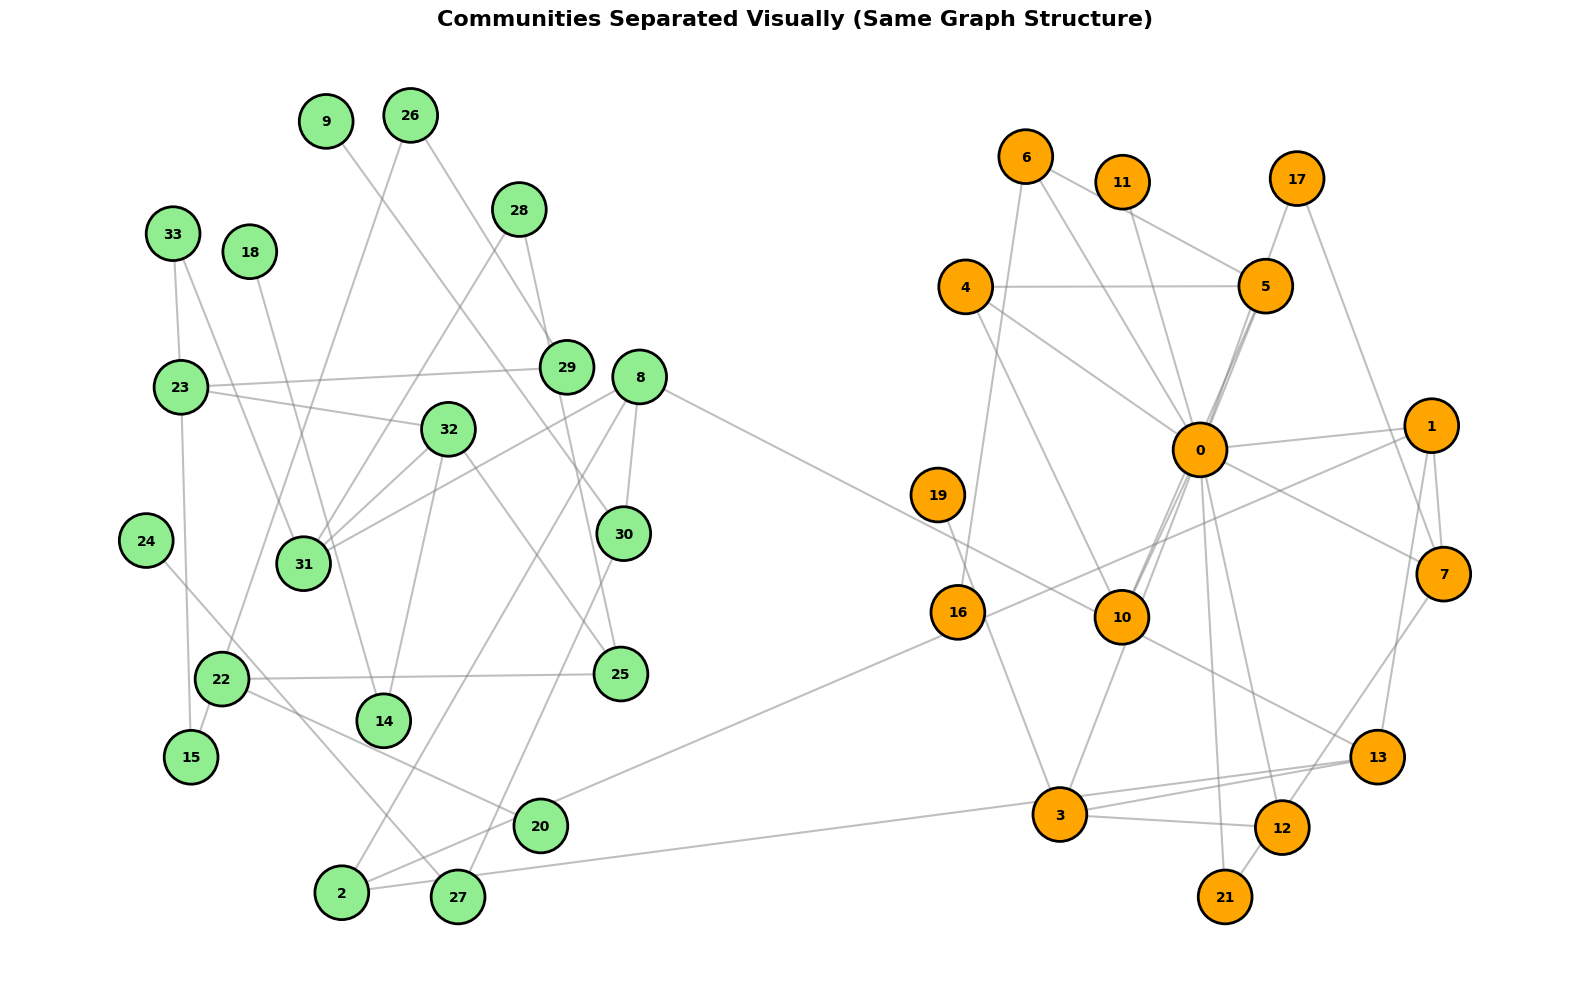

✓ Same graph structure maintained
✓ Total edges: 47
✓ Green community nodes: 19
✓ Orange community nodes: 15
✓ Bridging edges visible: 6


In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Define communities
green_community = [26, 29, 15, 23, 32, 33, 25, 31, 28, 18, 14, 20, 22, 24, 27, 30, 9, 8, 2]
orange_community = [0, 1, 3, 7, 12, 11, 4, 5, 6, 10, 21, 17, 13, 19, 16]

# Define all edges
green_edges = [(26,29), (26,15), (29,23), (15,23), (23,32), (23,33), (32,25),
               (32,31), (33,31), (18,14), (14,32), (20,22), (22,25), (25,28),
               (31,28), (24,27), (27,30), (9,30), (30,8), (8,31), (8,2)]

orange_edges = [(0,1), (0,3), (0,7), (0,12), (0,11), (0,4), (0,5), (0,6),
                (0,10), (0,21), (0,17), (1,7), (1,13), (3,13), (3,12), (3,19),
                (7,21), (7,17), (4,5), (5,6), (5,10), (6,16), (10,4)]

# Bridging edges
bridging_edges = [(2,13), (2,1), (13,3), (13,8), (2,8), (8,31)]

# Create graph with all edges
G = nx.Graph()
G.add_edges_from(green_edges + orange_edges + bridging_edges)

# Create custom layout: position communities on opposite sides
pos = {}

# Position green community on the LEFT
green_pos = nx.spring_layout(nx.subgraph(G, green_community), k=2, iterations=50, seed=42)
for node, (x, y) in green_pos.items():
    pos[node] = (x - 1.5, y)  # Shift left (decreased distance)

# Position orange community on the RIGHT
orange_pos = nx.spring_layout(nx.subgraph(G, orange_community), k=2, iterations=50, seed=42)
for node, (x, y) in orange_pos.items():
    pos[node] = (x + 1.5, y)  # Shift right (decreased distance)

# Plot
plt.figure(figsize=(16, 10))

# Color nodes based on community
node_colors = []
for node in G.nodes():
    if node in green_community:
        node_colors.append('#90EE90')  # Light green
    else:
        node_colors.append('#FFA500')  # Orange

# Draw edges
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5, edge_color='gray')

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500, 
                      edgecolors='black', linewidths=2)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title('Communities Separated Visually (Same Graph Structure)', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

print("✓ Same graph structure maintained")
print(f"✓ Total edges: {G.number_of_edges()}")
print(f"✓ Green community nodes: {len(green_community)}")
print(f"✓ Orange community nodes: {len(orange_community)}")
print(f"✓ Bridging edges visible: {len(bridging_edges)}")

In [7]:
import networkx as nx

# Define communities
green_community = [26, 29, 15, 23, 32, 33, 25, 31, 28, 18, 14, 20, 22, 24, 27, 30, 9, 8, 2]
orange_community = [0, 1, 3, 7, 12, 11, 4, 5, 6, 10, 21, 17, 13, 19, 16]

# Define all edges
green_edges = [(26,29), (26,15), (29,23), (15,23), (23,32), (23,33), (32,25),
               (32,31), (33,31), (18,14), (14,32), (20,22), (22,25), (25,28),
               (31,28), (24,27), (27,30), (9,30), (30,8), (8,31), (8,2)]

orange_edges = [(0,1), (0,3), (0,7), (0,12), (0,11), (0,4), (0,5), (0,6),
                (0,10), (0,21), (0,17), (1,7), (1,13), (3,13), (3,12), (3,19),
                (7,21), (7,17), (4,5), (5,6), (5,10), (6,16), (10,4)]

bridging_edges = [(2,13), (2,1), (13,3), (13,8), (2,8), (8,31)]

# Create graph
G = nx.Graph()
G.add_edges_from(green_edges + orange_edges + bridging_edges)

# Add community attribute to each node
for node in G.nodes():
    if node in green_community:
        G.nodes[node]['community'] = 'Green'
    else:
        G.nodes[node]['community'] = 'Orange'

# Export to GEXF format
G_gexf = G.copy()
nx.write_gexf(G_gexf, 'communities_graph.gexf')

print("✓ Graph exported as 'communities_graph.gexf'")
print(f"✓ Nodes: {G.number_of_nodes()}")
print(f"✓ Edges: {G.number_of_edges()}")
print("\nNext steps:")
print("1. Open Gephi")
print("2. Go to File > Open")
print("3. Select 'communities_graph.gexf'")
print("4. Click 'OK' to import")


✓ Graph exported as 'communities_graph.gexf'
✓ Nodes: 34
✓ Edges: 47

Next steps:
1. Open Gephi
2. Go to File > Open
3. Select 'communities_graph.gexf'
4. Click 'OK' to import
